In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from scipy.stats import binom

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [3]:
import sys, IPython, scipy, matplotlib, pandas, platform
print("""This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nArviZ {}\nNumPy {}\nSciPy {}\nPandas {}\nMatplotlib {}\n""".format(sys.version[:5], IPython.__version__, pm.__version__, az.__version__, np.__version__, scipy.__version__, pandas.__version__, matplotlib.__version__))

This notebook was created using:
Python 3.7.4
IPython 7.13.0
PyMC3 3.8
ArviZ 0.7.0
NumPy 1.18.2
SciPy 1.4.1
Pandas 1.0.3
Matplotlib 3.2.1



### 1. The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.

In [4]:
# load data
d = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
# filter out people < 18
d_adult = d[d.age>=18]
d_adult.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [5]:
# define model
xbar = d_adult.weight.mean()
with pm.Model() as m_adult:
    a = pm.Normal('a', mu=178, sigma=20)
    b = pm.Lognormal('b', mu=0, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic("mu", a + b*(d_adult.weight-xbar))
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d_adult.height)
    trace_m_adult = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4053.33draws/s]


In [6]:
# show summary
varnames = ["~mu"]
az.summary(trace_m_adult, varnames, round_to=2, kind="stats")

,mean,sd,hpd_3%,hpd_97%
a,154.60,0.27,154.09,155.11
b,0.90,0.04,0.82,0.98
sigma,5.11,0.20,4.75,5.48


In [7]:
# calculate expected height
weight = np.array([45, 40, 65, 31, 53])
# init saving space
mu_pred = np.zeros((len(weight), len(trace_m_adult) * trace_m_adult.nchains))
# calculate posterior for each mu
for n, w in enumerate(weight):
    mu_pred[n] = trace_m_adult['a'] + trace_m_adult['b']*(w - d_adult.weight.mean())

In [8]:
height_exp = mu_pred.mean(1)

In [9]:
# calculate ecompatibility intervals
post_samples = []
for _ in range(1000):  # number of samples from the posterior
    i = np.random.randint(len(trace_m_adult))
    mu_pr = trace_m_adult["a"][i] + trace_m_adult["b"][i] * (weight - d_adult.weight.mean())
    sigma_pred = trace_m_adult["sigma"][i]
    post_samples.append(np.random.normal(mu_pr, sigma_pred))

In [10]:
CI_89 = az.hpd(np.array(post_samples), credible_interval=0.89)

In [11]:
d = {'Weight': weight, 'Expected Height': height_exp, 'L89%': CI_89[:,0], 'U89%': CI_89[:,1]}
df = pd.DataFrame(data=d)

In [12]:
df.round(1)

,Weight,Expected Height,L89%,U89%
0,45,154.6,146.3,162.1
1,40,150.1,142.8,158.3
2,65,172.7,164.7,181.4
3,31,142.0,132.7,150.0
4,53,161.8,153.4,169.4


### 2. Model the relationship between height(cm) and the natural logarithm of weight (log-kg): log(weight). Use the entire Howell1 data frame, all 544 rows, adults and non-adults. Use any model type from Chapter 4 that you think useful: an ordinary linear regression, a polynomial or a spline. Plot the posterior predictions against the raw data.


In [13]:
# load data
d = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [14]:
# log-weight
d["weight"] = np.log(d.weight)

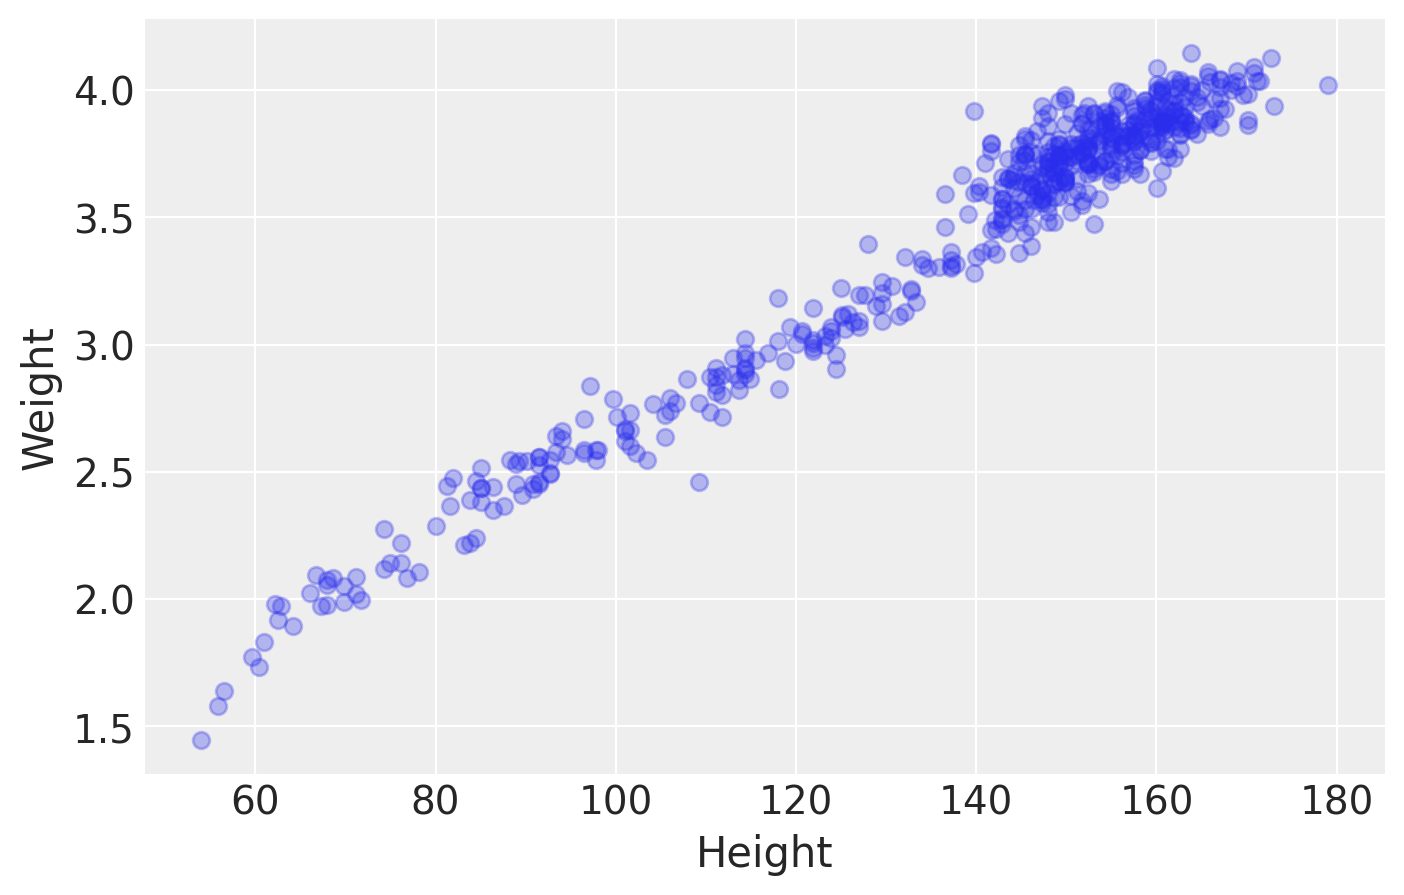

In [15]:
# plot the data
fig = plt.figure(figsize=(8, 5))
plt.plot(d.height, d.weight, 'o', alpha=0.3)
plt.xlabel('Height', fontsize=15)
plt.ylabel('Weight', fontsize=15)
plt.show()

In [16]:
# standardize data
d["weight_std"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_std2"] = d.weight_std ** 2

In [17]:
# define model quadratic regression
with pm.Model() as m_log:
    a = pm.Normal('a', mu=178, sigma=20)
    b1 = pm.Lognormal('b1', mu=0, sigma=1)
    b2 = pm.Normal('b2', mu=0, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic("mu", a + b1*d.weight_std + b2*d.weight_std2)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d.height)
    trace_m_log = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b2, b1, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2152.98draws/s]


In [18]:
# show model summary
varnames = ["~mu"]
az.summary(trace_m_log, varnames, round_to=2, kind="stats")

,mean,sd,hpd_3%,hpd_97%
a,139.19,0.30,138.65,139.77
b2,-0.93,0.21,-1.31,-0.52
b1,25.97,0.34,25.33,26.61
sigma,5.07,0.15,4.78,5.35


In [19]:
mu_pred = trace_m_log["mu"]
height_pred = pm.sample_posterior_predictive(trace=trace_m_log, samples=1000, model=m_log)

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 808.36it/s]


In [20]:
# calculate mean for quadratic curve
weight_seq = np.arange(-3.5, 1.5, 0.01)
height_seq = trace_m_log["a"].mean() + trace_m_log["b1"].mean()*weight_seq + trace_m_log["b2"].mean()*weight_seq**2

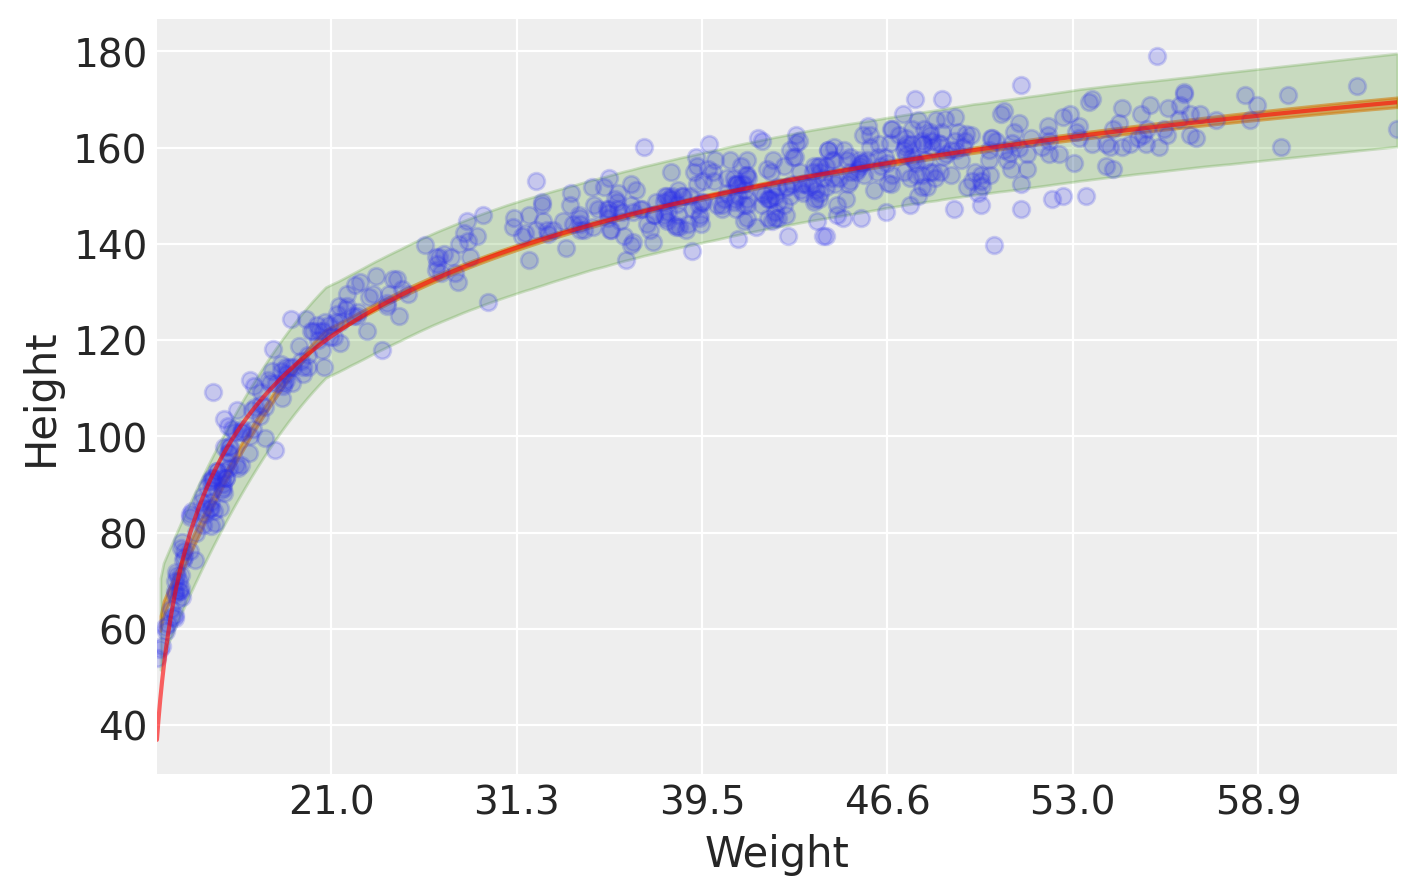

In [21]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(np.exp(d.weight_std), d.height, 'o', alpha=0.2)
# mean
plt.plot(np.exp(weight_seq), height_seq, "r", alpha=0.6)
# CI for mean
az.plot_hpd(np.exp(d.weight_std), mu_pred, color='C1', fill_kwargs={'alpha': 0.6})
# CI for height
az.plot_hpd(np.exp(d.weight_std), height_pred["height"], color='C2', fill_kwargs={'alpha': 0.2})
plt.ylabel('Height', fontsize=15)
plt.xlabel('Weight', fontsize=15)
at = np.arange(-5, 5, 0.5)
plt.xticks(at, np.round(np.exp(np.log(at)*d.weight.std()+d.weight.mean()), 1));
plt.xlim(np.exp(d.weight_std.min()), np.exp(d.weight_std.max()))
plt.show()

### 3. Plot the prior predictive distribution for the polynomial regression model in Chapter 4. You can modify the the code that plots the linear regression prior predictive distribution. 20 or 30 parabolas from the prior should suffice to show where the prior probability resides. Can you modify the prior distributions of $\alpha$, $\beta_1$, and $\beta_2$ so that the prior predictions stay within the biologically reasonable outcome space? That is to say: Do not try to fit the data by hand. But do try to keep the curves consistent with what you know about height and weight, before seeing these exact data.

In [22]:
# load data
d = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [23]:
# standardize data
d["weight_std"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_std2"] = d.weight_std ** 2

In [24]:
# define model quadratic regression
with pm.Model() as m4_5:
    a = pm.Normal('a', mu=178, sigma=20)
    b1 = pm.Lognormal('b1', mu=0, sigma=1)
    b2 = pm.Normal('b2', mu=0, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic("mu", a + b1*d.weight_std + b2*d.weight_std2)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d.height)
    trace_m4_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b2, b1, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2621.48draws/s]


In [25]:
# show model summary
varnames = ["~mu"]
az.summary(trace_m4_5, varnames, round_to=2, kind="stats")

,mean,sd,hpd_3%,hpd_97%
a,146.06,0.37,145.38,146.76
b2,-7.80,0.28,-8.33,-7.26
b1,21.74,0.29,21.20,22.30
sigma,5.80,0.17,5.48,6.12


In [26]:
# draw samples from prior
n_samples = 1000
sample_a = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
sample_b1 = stats.lognorm.rvs(s=1, loc=0, scale=1, size=n_samples)
sample_b2 = stats.norm.rvs(loc=0, scale=1, size=n_samples)

In [27]:
weight_seq = np.linspace(d.weight_std.min(), d.weight_std.max(), 50)

In [28]:
# init saving space
mu_pred = np.zeros((len(weight_seq), n_samples))
# calculate posterior for each mu
for n, w in enumerate(weight_seq):
    mu_pred[n] = sample_a + sample_b1*w + sample_b2*w**2

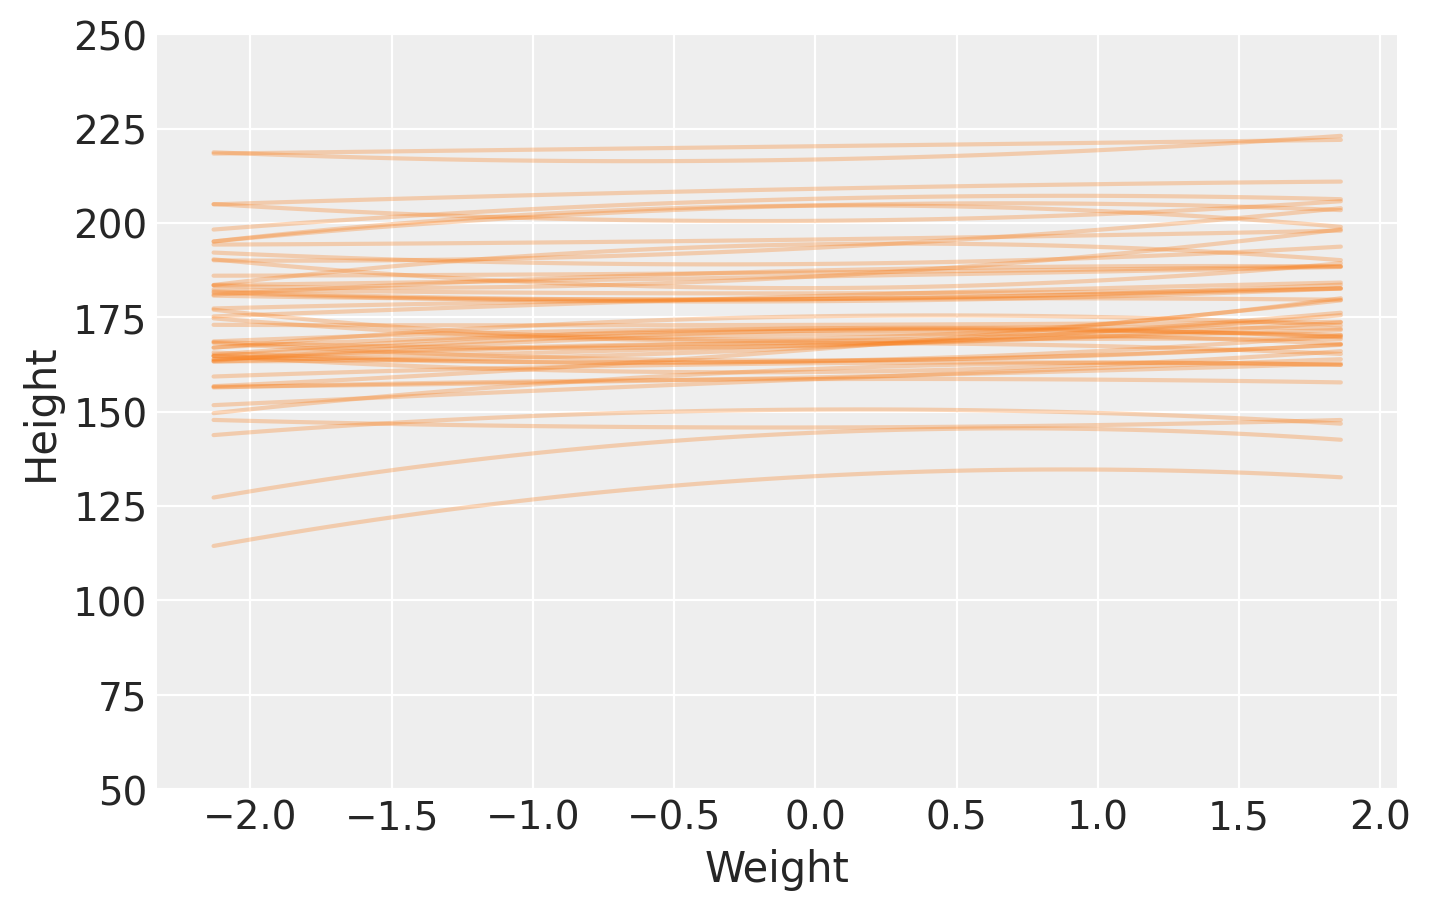

In [29]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(weight_seq, mu_pred[:,:50], "-C1", alpha=0.3)
plt.ylabel('Height', fontsize=15)
plt.xlabel('Weight', fontsize=15)
plt.ylim(50,250)
plt.show()

In [30]:
# increase the standard deviation on the b2 prior
sample_b2 = stats.norm.rvs(loc=0, scale=10, size=n_samples)

In [31]:
# init saving space
mu_pred = np.zeros((len(weight_seq), n_samples))
# calculate posterior for each mu
for n, w in enumerate(weight_seq):
    mu_pred[n] = sample_a + sample_b1*w + sample_b2*w**2

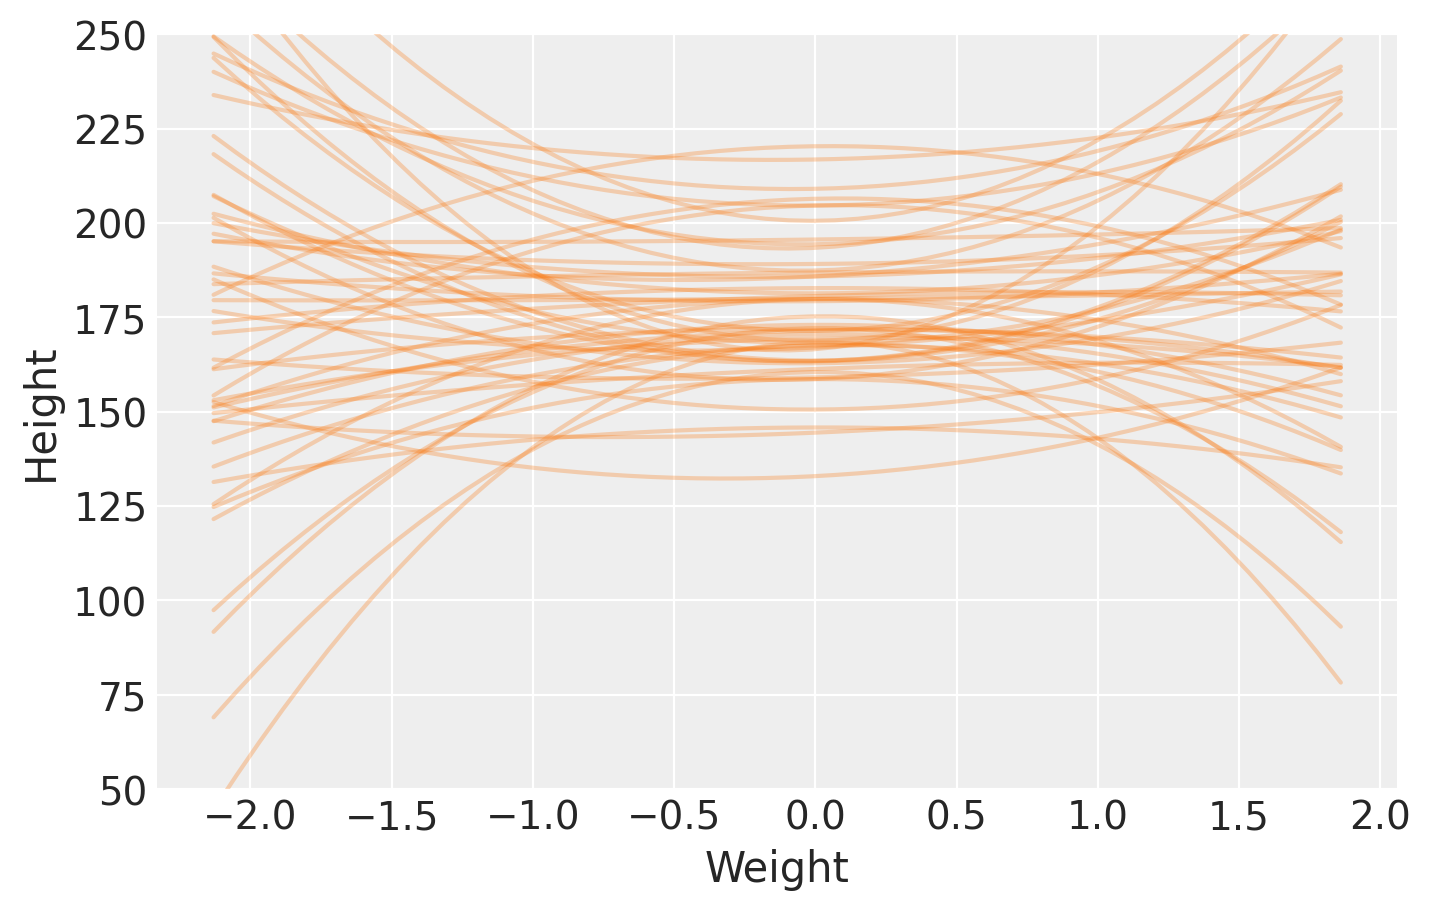

In [32]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(weight_seq, mu_pred[:,:50], "-C1", alpha=0.3)
plt.ylabel('Height', fontsize=15)
plt.xlabel('Weight', fontsize=15)
plt.ylim(50,250)
plt.show()

In [33]:
# change b1 and b2 prior
sample_b1 = stats.lognorm.rvs(s=1, loc=2, scale=1, size=n_samples)
sample_b2 = stats.lognorm.rvs(s=1, loc=1, scale=1, size=n_samples)

In [34]:
# init saving space
mu_pred = np.zeros((len(weight_seq), n_samples))
# calculate posterior for each mu
for n, w in enumerate(weight_seq):
    mu_pred[n] = sample_a + sample_b1*w - sample_b2*w**2

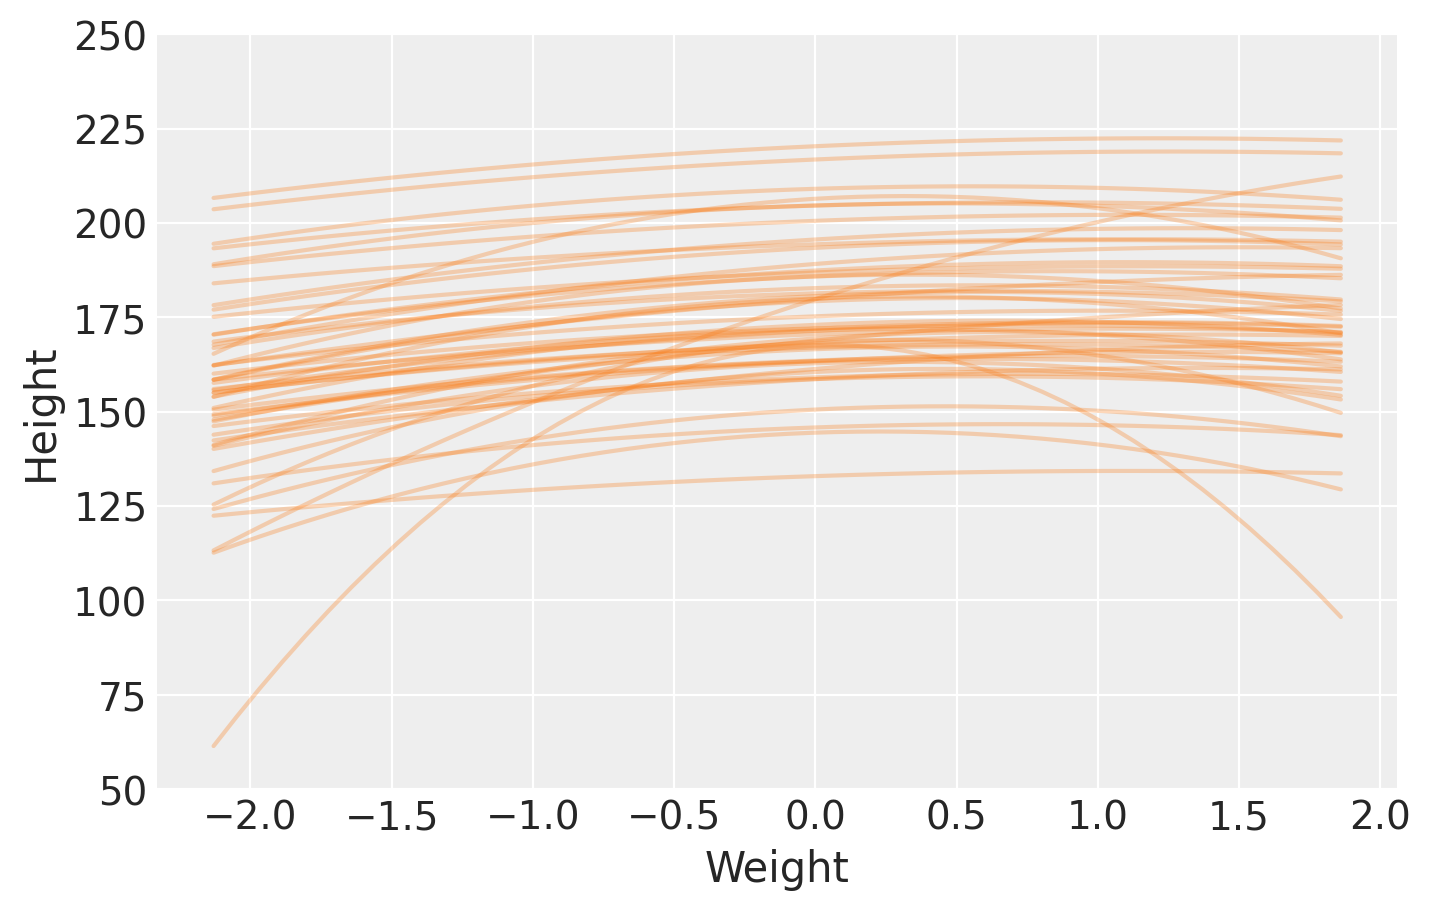

In [35]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(weight_seq, mu_pred[:,:50], "-C1", alpha=0.3)
plt.ylabel('Height', fontsize=15)
plt.xlabel('Weight', fontsize=15)
plt.ylim(50,250)
plt.show()

In [36]:
# change b1 and b2 prior
sample_b1 = stats.norm.rvs(loc=0, scale=100, size=n_samples)
sample_b2 = stats.norm.rvs(loc=0, scale=100, size=n_samples)

In [37]:
# init saving space
mu_pred = np.zeros((len(weight_seq), n_samples))
# calculate posterior for each mu
for n, w in enumerate(weight_seq):
    mu_pred[n] = sample_a + sample_b1*w + sample_b2*w**2

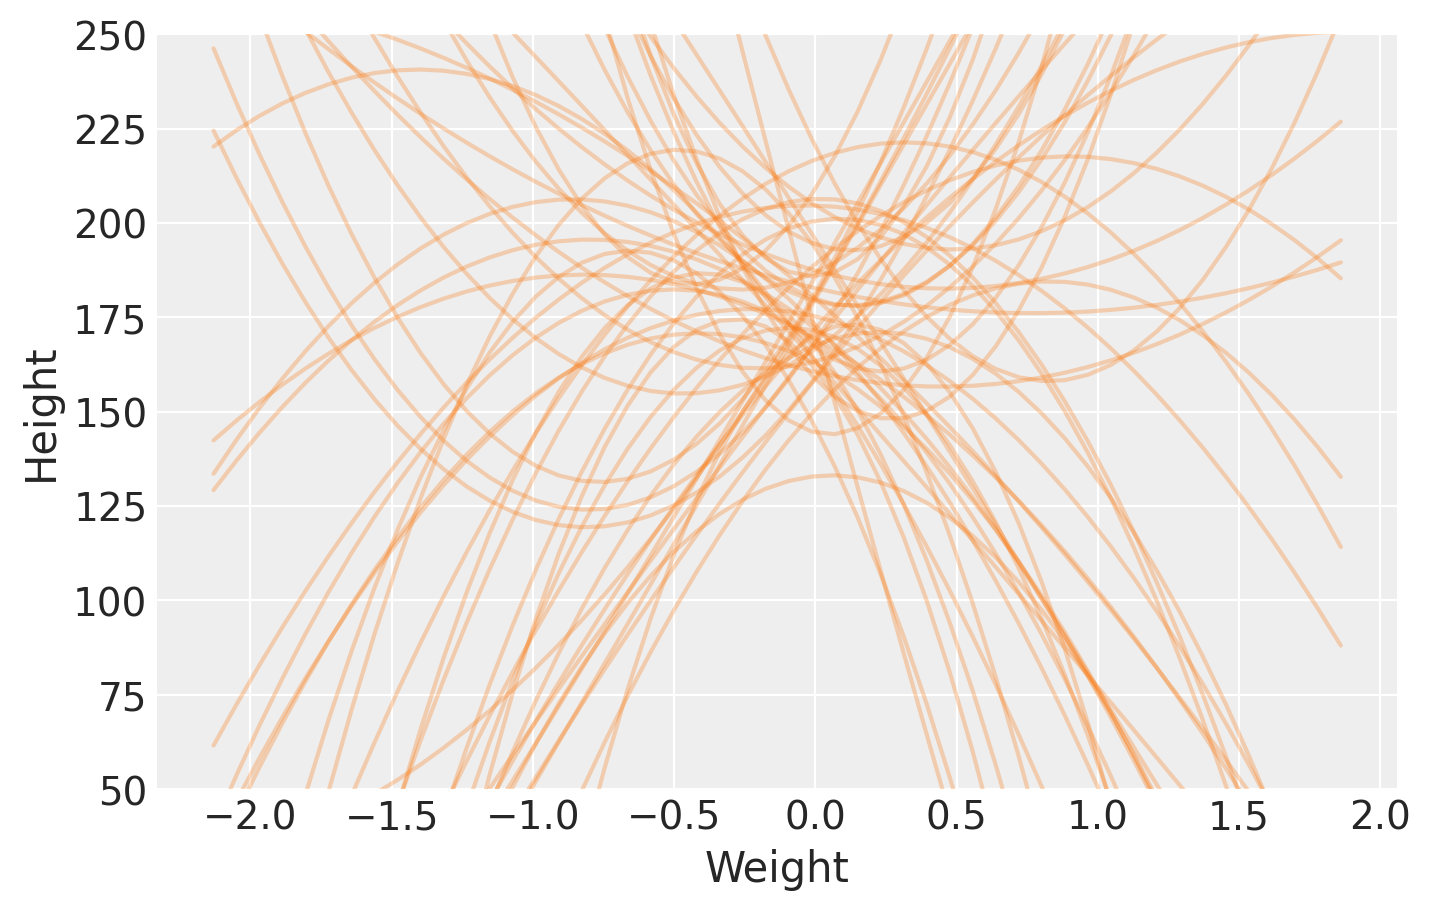

In [38]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(weight_seq, mu_pred[:,:50], "-C1", alpha=0.3)
plt.ylabel('Height', fontsize=15)
plt.xlabel('Weight', fontsize=15)
plt.ylim(50,250)
plt.show()